# PDAC Calibration - Double SEER incidence

Author: Sophie Wagner, sw3767@cumc.columbia.edu

In [1]:
# Required Packages
import numpy as np  # For matrix manipulation
import pandas as pd  # For output/input data processing
import matplotlib.pyplot as plt  # For visualizations
from csaps import csaps
from tqdm import tqdm
from datetime import datetime

# Add the src directory to the Python path
import sys
import os
sys.path.append(os.path.abspath('../src'))

# Load .py files
import common_functions as func
import calibration_plots as p
import configs as c
import gof

# Some aesthetic options
np.set_printoptions(suppress=True, linewidth=300, formatter={'float': '{: 0.9f}'.format})
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Set up matrix

In [2]:
def row_normalize(matrix):
    for age_layer in range(matrix.shape[0]):  # Loop over each age layer
        layer = matrix[age_layer]
        for row_idx in range(layer.shape[0]):  # Loop over each row
            row = layer[row_idx]
            
            # Exclude diagonal (stay-in-state) and ACM (all-cause mortality) from scaling
            acm_idx = -1  # Assuming ACM is the last state (adjust index if necessary)
            non_diag_sum = np.sum(row) - row[row_idx] - row[8]  # Exclude diagonal and ACM
            
            if non_diag_sum > 1:  # If the non-ACM probabilities exceed 1
                scaling_factor = 1 / non_diag_sum
                row[:-1] *= scaling_factor  # Scale all except the last column (ACM)
            
            # Adjust diagonal (stay-in-state probability)
            row[row_idx] = max(0, 1 - non_diag_sum - row[8])
    
    return matrix


def create_matrix():
    matrix = np.zeros((len(c.age_layers_1y), len(c.health_states_itos), len(c.health_states_itos)))
    matrix[:15, 0, 1] = 0.000002
    matrix[15:30, 0, 1] = np.linspace(0.00002, 0.0001, 15)
    matrix[30:55, 0, 1] = np.linspace(0.0001, 0.0006, 25)
    matrix[55:, 0, 1] = 0.0006
    matrix[:, 1, 2] = 0.380016  # c.model_inputs_dict['p_Local_to_Regional_PC']
    matrix[:, 2, 3] = 0.666632  # c.model_inputs_dict['p_Regional_to_Distant_PC']
    matrix[:, 1, 4] = 0.040325  # c.model_inputs_dict['p_symptom_local']
    matrix[:, 2, 5] = 0.328861  # c.model_inputs_dict['p_symptom_regional']
    matrix[:, 3, 6] = 0.332143  # c.model_inputs_dict['p_symptom_distant']
    

    matrix = add_acm(matrix)  # ACM
    matrix = add_csd(matrix)  # CSD
    matrix = constrain_matrix(matrix)  # constrain
    matrix = row_normalize(matrix)  # normalize

    return matrix


def constrain_matrix(matrix):
    matrix = np.clip(matrix, 0.000001, 1.0)
    matrix[:, 0, 1] = np.maximum.accumulate(matrix[:, 0, 1])
    matrix[:, 1, 2] = np.maximum(matrix[:, 0, 1], matrix[:, 1, 2])
    matrix[:, 2, 3] = np.maximum(matrix[:, 1, 2], matrix[:, 2, 3])
    matrix[:, 2, 5] = np.maximum(matrix[:, 1, 4], matrix[:, 2, 5])
    matrix[:, 3, 6] = np.maximum(matrix[:, 2, 5], matrix[:, 3, 6])
    
    return matrix


def add_acm(matrix):
    if matrix.shape[0] == 65:
        matrix[:, :7, 8] = c.acm_1y[:65, np.newaxis]  # Healthy to ACM
    else:
        matrix[:, :7, 8] = c.acm_1y[:, np.newaxis]  # Healthy to ACM
    matrix[:, 8, 8] = 1
    return matrix


def add_csd(matrix):
    matrix[:, 4, 7] = int(c.model_inputs_dict['p_local_death'])
    matrix[:, 5, 7] = int(c.model_inputs_dict['p_regional_death'])
    matrix[:, 6, 7] = int(c.model_inputs_dict['p_distant_death'])
    matrix[:, 7, 7] = 1
    return matrix

## Step function

In [3]:
def step(matrix, step_size, num_adj=3):
    step_mat = np.random.choice(len(c.transitions_itos), size=num_adj, replace=True)
    points = list(c.transitions_itos.keys()) 
    step_age = np.random.choice(range(8, 13), size=num_adj, replace=True) # Only select age groups after 60
    small_matrix = matrix[::5, :, :]
    for i in range(num_adj):
        from_state, to_state = points[step_mat[i]]
        step_param = small_matrix[step_age[i], from_state, to_state] * step_size
        small_matrix[step_age[i], from_state, to_state] += np.random.uniform(low=-step_param, high=step_param)
    
    # Update params after age 60
    small_matrix[12, :, :] = np.minimum(small_matrix[11, :, :], small_matrix[12, :, :])
    new_matrix = np.copy(matrix)
    new_matrix[40:,:,:] = csaps([62.5,67.5,72.5,77.5,82.5], small_matrix[8:], axis=0, smooth=0.001)(c.ages_1y[40:])
    assert new_matrix.shape[0]==65, "new_matrix not updated properly, incorrect shape."
    new_matrix = constrain_matrix(new_matrix)
    new_matrix = add_acm(new_matrix)
    new_matrix = add_csd(new_matrix)
    new_matrix = row_normalize(new_matrix)

    return new_matrix

## Run markov

In [11]:
def run_markov(matrix, starting_age=20, max_age=84):
    
    current_age = starting_age
    age_layer = 0
    month_pop, pop_log = c.starting_pop, c.starting_pop  # (13, 1)
    
    inc_log = np.zeros(pop_log.shape)  # to track new incidences in each state
    matrixT = matrix.transpose(0,2,1)  # (65, 13, 13)
    inflow_matrix = np.tril(matrixT, k=-1)
    old_risk, new_risk = 0, 1
    while current_age < max_age:            

        # Matrix multiplication (state transition)
        inflow_mat = inflow_matrix[age_layer] 
        mat = matrixT[age_layer]
        month_inc = np.matmul(inflow_mat, month_pop)  # (9, 9)(9, 1)->(9, 1)
        month_pop = np.matmul(mat, month_pop)  # (9, 9)(9, 1)->(9, 1)
         
        # Add to log
        inc_log = np.concatenate((inc_log, month_inc), axis=1)  # (13, 65)
        pop_log = np.concatenate((pop_log, month_pop), axis=1)  # (13, 65)
        
        current_age += 1
        if age_layer < matrix.shape[0]-1:  # if we run 85-100 stay at 85
            age_layer += 1
            
    incidence, incidence_unadj = inc_log.copy(), inc_log.copy()
    dead_factor = np.divide(c.N, c.N - pop_log[7:, :].sum(axis=0))  # inc and prev denominator is out of living only
    prevalence = np.zeros(pop_log.shape) 

    for state in range(9):
        incidence[state, :] = np.multiply(incidence[state, :], dead_factor)
        prevalence[state, :] = np.multiply(pop_log[state, :], dead_factor)
        
    # assert np.allclose(pop_log[:,:40], c.starting_pop_log[:,:-1], atol=1e-6), "First 40 years mismatch."
    # assert np.allclose(inc_log[:,:40], c.starting_inc_log[:,:-1], atol=1e-6), "First 40 years incidence mismatch."

    return incidence, prevalence, incidence_unadj, pop_log

## Simulated annealing

In [6]:
def simulated_annealing(n_iterations, step_size, start_tmat=None, n_adj=7, verbose=False):

    if start_tmat is None:
        start_tmat = create_matrix()

    best_t = np.copy(start_tmat)
    best_log = run_markov(best_t)
    best_eval = gof.objective(best_log)  # evaluate the initial point
    curr_t, curr_eval = best_t, best_eval  # current working solution
    ticker = 0

    with tqdm(total=n_iterations, desc="Simulated annealing progress", unit="iteration") as pbar:
        
        for i in range(n_iterations):

            # Run model
            candidate_t = np.copy(curr_t)
            candidate_t = step(candidate_t, step_size, n_adj)
            candidate_log = run_markov(candidate_t)
            candidate_eval = gof.objective(candidate_log)  # Evaluate candidate point

            # Update "best" if better than candidate
            if candidate_eval < best_eval:
                ticker = 0
                best_t, best_eval = np.copy(candidate_t), np.copy(candidate_eval)
                best_log = run_markov(best_t)

            else:
                ticker += 1

            # t = 10 / float(i+1)  # calculate temperature for current epoch
            t = 1 / (1 + 0.1 * np.log(i + 1))  # Slower cooling

            # Progress report
            if verbose and i % 1000 == 0:
                log_adj, _, inc_log, _ = best_log
                total_dxd = np.sum(inc_log[4:7, :]) / c.N
                print(i, ": ", best_eval, "   PDAC: ", round(total_dxd, 5),"   tick:",ticker)
                if i % 10000 == 0:
                    transition_probs = p.extract_transition_probs(best_t)
                    print(f"Progress report, i = {i}")
                    print(transition_probs)
                    p.plot_vs_seer(log_adj, c.seer_inc)

            # Check if we should update "curr"
            diff = (candidate_eval - curr_eval)  # difference between candidate and current point evaluation
            metropolis = np.exp(-diff / t)  # calculate metropolis acceptance criterion
            if (diff < 0 or np.random.random() < metropolis):  # check if we should keep the new point
                curr_t, curr_eval = np.copy(candidate_t), np.copy(candidate_eval)  # store the new current point
                ticker = 0

            pbar.update(1)

    print(best_eval)
    
    return best_t

## Run 

In [13]:
def run_sa(tmat=None, save_all=False):
    if tmat is None:
        tmat = create_matrix()
    result = simulated_annealing(n_iterations=100000, step_size=0.25, start_tmat=tmat, n_adj=5, verbose=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M")
    
    
    curr_tmat = result.copy()
    curr_log = run_markov(curr_tmat)
    log_adj, log_prev, log_inc, pop_log = curr_log

    # Extract transition probabilities
    transition_probs = p.extract_transition_probs(curr_tmat)

    # Saving
    if save_all:
        # Save the with the timestamp in the filenames
        output_dir = c.OUTPUT_PATHS[type]
        log_path, tmat_path, plot_path = c.OUTPUT_PATHS["logs"], c.OUTPUT_PATHS["tmats"], c.OUTPUT_PATHS["plots"]
        np.save(f"{tmat_path}/{timestamp}_tmat.npy", curr_tmat)
        pd.DataFrame(log_adj).to_csv(f"{log_path}/{timestamp}_inc_adj.csv")
        pd.DataFrame(log_prev).to_csv(f"{log_path}/{timestamp}_prev.csv")
        pd.DataFrame(log_inc).to_csv(f"{log_path}/{timestamp}_inc_unadj.csv")
        transition_probs.to_csv(f"{log_path}/{timestamp}_tps.csv")
        p.plot_vs_seer(curr_log, c.seer_inc, save_imgs=True, outpath=plot_path, timestamp=timestamp)
        p.plot_vs_seer_total(curr_log, c.seer_inc, save_imgs=True, outpath=plot_path, timestamp=timestamp)

    else:
        print(transition_probs)
        p.plot_vs_seer(log_adj, c.seer_inc)
        p.plot_vs_seer_total(log_adj, c.seer_inc)
        print(pd.DataFrame(pop_log.T))

    return curr_tmat

In [8]:
tmat = np.load("../out/tmats/20241205_1310_tmat.npy")

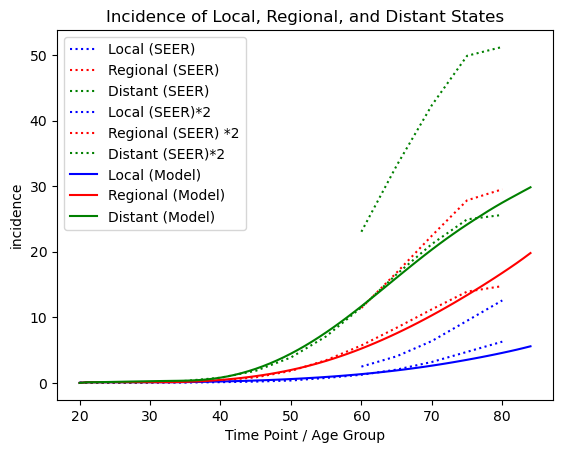

In [12]:
log = run_markov(tmat)
p.plot_vs_seer(log[0], c.seer_inc)

Simulated annealing progress:   0%|          | 0/100000 [00:00<?, ?iteration/s]

0 :  2466.286190612331    PDAC:  0.00783    tick: 1
Progress report, i = 0
   From State    To State  Probability
0     healthy  u_PDAC_loc     0.000001
1  u_PDAC_loc  u_PDAC_reg     0.303776
2  u_PDAC_reg  u_PDAC_dis     0.602806
3  u_PDAC_loc  d_PDAC_loc     0.011480
4  u_PDAC_reg  d_PDAC_reg     0.059878
5  u_PDAC_dis  d_PDAC_dis     0.102158


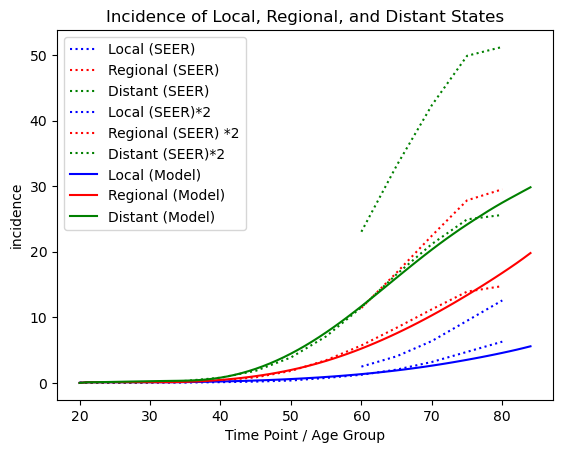

Simulated annealing progress:   0%|          | 454/100000 [00:03<13:14, 125.29iteration/s]C:\Users\sophi\AppData\Local\Temp\ipykernel_41504\3595011624.py:47: RuntimeWarning: overflow encountered in exp
  metropolis = np.exp(-diff / t)  # calculate metropolis acceptance criterion
Simulated annealing progress:   1%|          | 1018/100000 [00:07<11:22, 145.07iteration/s]

1000 :  307.57926470468726    PDAC:  0.01182    tick: 348


Simulated annealing progress:   2%|▏         | 2017/100000 [00:15<14:45, 110.60iteration/s]

2000 :  297.4613406641888    PDAC:  0.01167    tick: 165


Simulated annealing progress:   3%|▎         | 3022/100000 [00:22<12:10, 132.75iteration/s]

3000 :  297.4613406641888    PDAC:  0.01167    tick: 1165


Simulated annealing progress:   4%|▍         | 4018/100000 [00:30<11:36, 137.86iteration/s]

4000 :  297.4613406641888    PDAC:  0.01167    tick: 2165


Simulated annealing progress:   5%|▌         | 5009/100000 [00:41<20:52, 75.83iteration/s] 

5000 :  297.4613406641888    PDAC:  0.01167    tick: 3165


Simulated annealing progress:   6%|▌         | 6013/100000 [00:54<19:17, 81.19iteration/s]

6000 :  297.4613406641888    PDAC:  0.01167    tick: 4165


Simulated annealing progress:   7%|▋         | 7008/100000 [01:07<18:17, 84.70iteration/s]

7000 :  297.4613406641888    PDAC:  0.01167    tick: 5165


Simulated annealing progress:   8%|▊         | 8016/100000 [01:19<19:45, 77.59iteration/s]

8000 :  297.4613406641888    PDAC:  0.01167    tick: 6165


Simulated annealing progress:   9%|▉         | 9012/100000 [01:31<16:10, 93.72iteration/s]

9000 :  297.4613406641888    PDAC:  0.01167    tick: 7165


Simulated annealing progress:  10%|▉         | 9999/100000 [01:42<19:13, 78.00iteration/s] 

10000 :  297.4613406641888    PDAC:  0.01167    tick: 8165
Progress report, i = 10000
   From State    To State  Probability
0     healthy  u_PDAC_loc     0.000001
1  u_PDAC_loc  u_PDAC_reg     0.303776
2  u_PDAC_reg  u_PDAC_dis     0.602806
3  u_PDAC_loc  d_PDAC_loc     0.011480
4  u_PDAC_reg  d_PDAC_reg     0.059878
5  u_PDAC_dis  d_PDAC_dis     0.102158


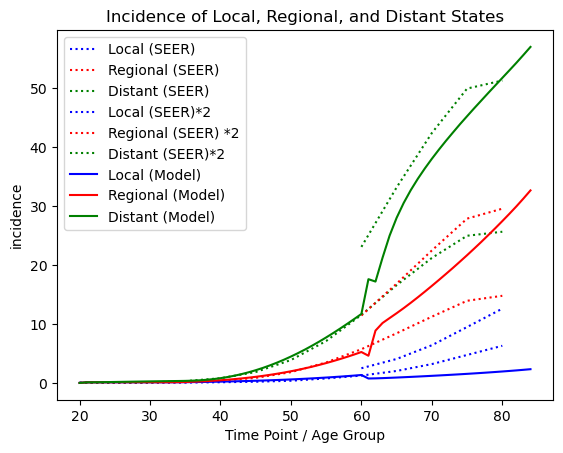

Simulated annealing progress:  11%|█         | 11015/100000 [01:57<16:56, 87.57iteration/s]

11000 :  297.4613406641888    PDAC:  0.01167    tick: 9165


Simulated annealing progress:  12%|█▏        | 12016/100000 [02:05<10:31, 139.30iteration/s]

12000 :  297.4613406641888    PDAC:  0.01167    tick: 10165


Simulated annealing progress:  13%|█▎        | 13017/100000 [02:12<11:28, 126.34iteration/s]

13000 :  297.4613406641888    PDAC:  0.01167    tick: 11165


Simulated annealing progress:  14%|█▍        | 14020/100000 [02:20<12:17, 116.64iteration/s]

14000 :  297.4613406641888    PDAC:  0.01167    tick: 12165


Simulated annealing progress:  15%|█▌        | 15018/100000 [02:32<16:29, 85.88iteration/s] 

15000 :  297.4613406641888    PDAC:  0.01167    tick: 13165


Simulated annealing progress:  16%|█▌        | 16010/100000 [02:43<14:26, 96.98iteration/s] 

16000 :  297.4613406641888    PDAC:  0.01167    tick: 14165


Simulated annealing progress:  17%|█▋        | 17016/100000 [02:53<13:59, 98.84iteration/s] 

17000 :  297.4613406641888    PDAC:  0.01167    tick: 15165


Simulated annealing progress:  18%|█▊        | 18011/100000 [03:05<18:31, 73.79iteration/s] 

18000 :  297.4613406641888    PDAC:  0.01167    tick: 16165


Simulated annealing progress:  19%|█▉        | 19015/100000 [03:16<13:58, 96.62iteration/s] 

19000 :  297.4613406641888    PDAC:  0.01167    tick: 17165


Simulated annealing progress:  20%|█▉        | 19997/100000 [03:26<21:24, 62.30iteration/s] 

20000 :  297.4613406641888    PDAC:  0.01167    tick: 18165
Progress report, i = 20000
   From State    To State  Probability
0     healthy  u_PDAC_loc     0.000001
1  u_PDAC_loc  u_PDAC_reg     0.303776
2  u_PDAC_reg  u_PDAC_dis     0.602806
3  u_PDAC_loc  d_PDAC_loc     0.011480
4  u_PDAC_reg  d_PDAC_reg     0.059878
5  u_PDAC_dis  d_PDAC_dis     0.102158


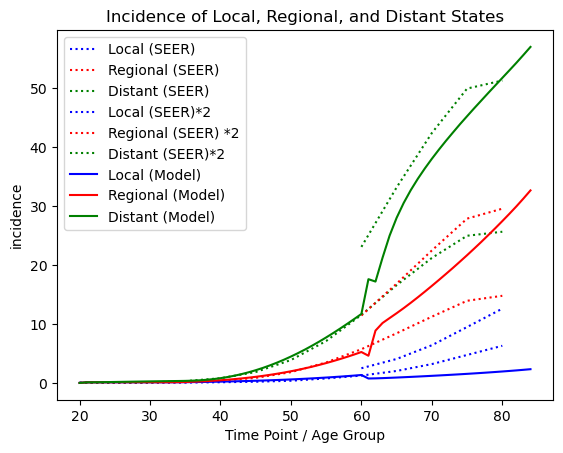

Simulated annealing progress:  21%|██        | 21013/100000 [03:38<12:25, 106.01iteration/s]

21000 :  297.4613406641888    PDAC:  0.01167    tick: 19165


Simulated annealing progress:  22%|██▏       | 22014/100000 [03:49<16:40, 77.97iteration/s] 

22000 :  297.4613406641888    PDAC:  0.01167    tick: 20165


Simulated annealing progress:  23%|██▎       | 23014/100000 [03:57<09:19, 137.48iteration/s]

23000 :  297.4613406641888    PDAC:  0.01167    tick: 21165


Simulated annealing progress:  24%|██▍       | 24021/100000 [04:05<09:11, 137.66iteration/s]

24000 :  297.4613406641888    PDAC:  0.01167    tick: 22165


Simulated annealing progress:  25%|██▌       | 25020/100000 [04:12<08:26, 148.11iteration/s]

25000 :  297.4613406641888    PDAC:  0.01167    tick: 23165


Simulated annealing progress:  26%|██▌       | 26030/100000 [04:20<08:20, 147.87iteration/s]

26000 :  297.4613406641888    PDAC:  0.01167    tick: 24165


Simulated annealing progress:  27%|██▋       | 27015/100000 [04:27<08:12, 148.22iteration/s]

27000 :  297.4613406641888    PDAC:  0.01167    tick: 25165


Simulated annealing progress:  28%|██▊       | 28018/100000 [04:35<09:31, 126.02iteration/s]

28000 :  297.4613406641888    PDAC:  0.01167    tick: 26165


Simulated annealing progress:  29%|██▉       | 29018/100000 [04:42<09:13, 128.23iteration/s]

29000 :  297.4613406641888    PDAC:  0.01167    tick: 27165


Simulated annealing progress:  30%|██▉       | 29994/100000 [04:50<08:05, 144.09iteration/s]

30000 :  297.4613406641888    PDAC:  0.01167    tick: 28165
Progress report, i = 30000
   From State    To State  Probability
0     healthy  u_PDAC_loc     0.000001
1  u_PDAC_loc  u_PDAC_reg     0.303776
2  u_PDAC_reg  u_PDAC_dis     0.602806
3  u_PDAC_loc  d_PDAC_loc     0.011480
4  u_PDAC_reg  d_PDAC_reg     0.059878
5  u_PDAC_dis  d_PDAC_dis     0.102158


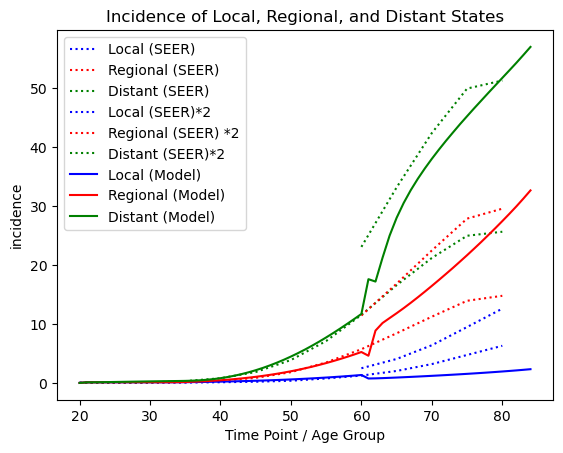

Simulated annealing progress:  31%|███       | 31019/100000 [04:57<08:16, 138.85iteration/s]

31000 :  297.4613406641888    PDAC:  0.01167    tick: 29165


Simulated annealing progress:  32%|███▏      | 32020/100000 [05:05<09:41, 116.88iteration/s]

32000 :  297.4613406641888    PDAC:  0.01167    tick: 30165


Simulated annealing progress:  33%|███▎      | 33009/100000 [05:14<12:57, 86.19iteration/s] 

33000 :  297.4613406641888    PDAC:  0.01167    tick: 31165


Simulated annealing progress:  34%|███▍      | 34022/100000 [05:24<10:00, 109.80iteration/s]

34000 :  297.4613406641888    PDAC:  0.01167    tick: 32165


Simulated annealing progress:  35%|███▌      | 35022/100000 [05:33<09:46, 110.75iteration/s]

35000 :  297.4613406641888    PDAC:  0.01167    tick: 33165


Simulated annealing progress:  36%|███▌      | 36020/100000 [05:42<09:38, 110.52iteration/s]

36000 :  297.4613406641888    PDAC:  0.01167    tick: 34165


Simulated annealing progress:  37%|███▋      | 37016/100000 [05:51<09:57, 105.46iteration/s]

37000 :  297.4613406641888    PDAC:  0.01167    tick: 35165


Simulated annealing progress:  38%|███▊      | 38019/100000 [06:00<09:25, 109.66iteration/s]

38000 :  297.4613406641888    PDAC:  0.01167    tick: 36165


Simulated annealing progress:  39%|███▉      | 39010/100000 [06:11<13:24, 75.84iteration/s] 

39000 :  297.4613406641888    PDAC:  0.01167    tick: 37165


Simulated annealing progress:  40%|███▉      | 39995/100000 [06:23<09:51, 101.52iteration/s]

40000 :  297.4613406641888    PDAC:  0.01167    tick: 38165
Progress report, i = 40000
   From State    To State  Probability
0     healthy  u_PDAC_loc     0.000001
1  u_PDAC_loc  u_PDAC_reg     0.303776
2  u_PDAC_reg  u_PDAC_dis     0.602806
3  u_PDAC_loc  d_PDAC_loc     0.011480
4  u_PDAC_reg  d_PDAC_reg     0.059878
5  u_PDAC_dis  d_PDAC_dis     0.102158


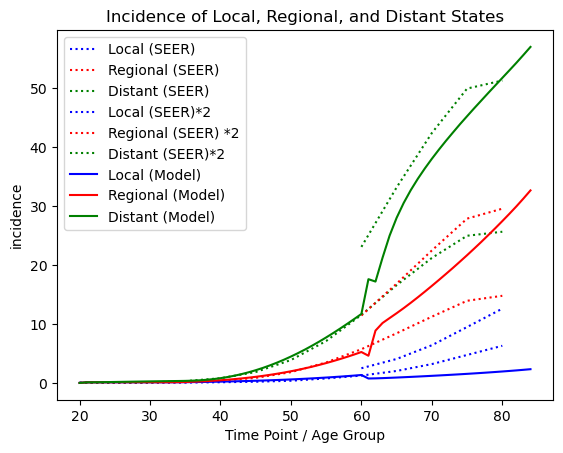

Simulated annealing progress:  41%|████      | 41010/100000 [06:35<14:13, 69.08iteration/s] 

41000 :  297.25159297634923    PDAC:  0.01171    tick: 776


Simulated annealing progress:  42%|████▏     | 42016/100000 [06:48<10:17, 93.88iteration/s] 

42000 :  297.25159297634923    PDAC:  0.01171    tick: 1776


Simulated annealing progress:  43%|████▎     | 43010/100000 [06:59<10:30, 90.35iteration/s] 

43000 :  297.25159297634923    PDAC:  0.01171    tick: 2776


Simulated annealing progress:  44%|████▍     | 44021/100000 [07:09<08:52, 105.12iteration/s]

44000 :  297.25159297634923    PDAC:  0.01171    tick: 3776


Simulated annealing progress:  45%|████▌     | 45014/100000 [07:18<09:24, 97.41iteration/s] 

45000 :  297.25159297634923    PDAC:  0.01171    tick: 4776


Simulated annealing progress:  46%|████▌     | 46016/100000 [07:28<09:23, 95.73iteration/s] 

46000 :  297.25159297634923    PDAC:  0.01171    tick: 5776


Simulated annealing progress:  47%|████▋     | 47015/100000 [07:38<08:30, 103.71iteration/s]

47000 :  297.25159297634923    PDAC:  0.01171    tick: 6776


Simulated annealing progress:  48%|████▊     | 48012/100000 [07:48<08:06, 106.78iteration/s]

48000 :  297.25159297634923    PDAC:  0.01171    tick: 7776


Simulated annealing progress:  49%|████▉     | 49011/100000 [07:58<08:46, 96.86iteration/s] 

49000 :  297.25159297634923    PDAC:  0.01171    tick: 8776


Simulated annealing progress:  50%|█████     | 50000/100000 [08:09<10:22, 80.33iteration/s] 

50000 :  297.25159297634923    PDAC:  0.01171    tick: 9776
Progress report, i = 50000
   From State    To State  Probability
0     healthy  u_PDAC_loc     0.000001
1  u_PDAC_loc  u_PDAC_reg     0.303776
2  u_PDAC_reg  u_PDAC_dis     0.602806
3  u_PDAC_loc  d_PDAC_loc     0.011480
4  u_PDAC_reg  d_PDAC_reg     0.059878
5  u_PDAC_dis  d_PDAC_dis     0.102158


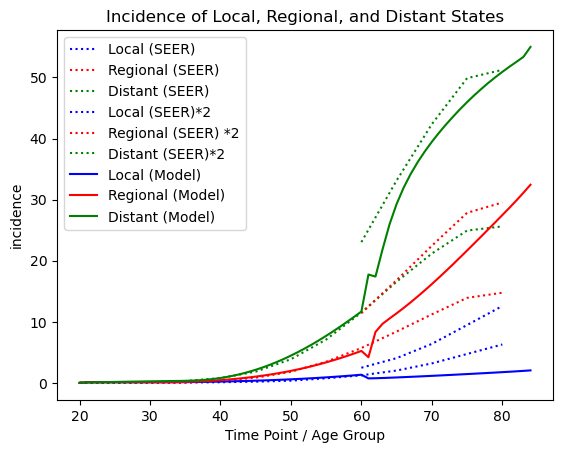

Simulated annealing progress:  51%|█████     | 51012/100000 [08:23<10:16, 79.47iteration/s]

51000 :  297.25159297634923    PDAC:  0.01171    tick: 10776


Simulated annealing progress:  52%|█████▏    | 52016/100000 [08:34<08:46, 91.17iteration/s] 

52000 :  297.25159297634923    PDAC:  0.01171    tick: 11776


Simulated annealing progress:  53%|█████▎    | 53015/100000 [08:46<10:47, 72.61iteration/s] 

53000 :  297.25159297634923    PDAC:  0.01171    tick: 12776


Simulated annealing progress:  54%|█████▍    | 54012/100000 [08:56<07:11, 106.68iteration/s]

54000 :  297.25159297634923    PDAC:  0.01171    tick: 13776


Simulated annealing progress:  55%|█████▌    | 55014/100000 [09:06<08:42, 86.14iteration/s] 

55000 :  297.25159297634923    PDAC:  0.01171    tick: 14776


Simulated annealing progress:  56%|█████▌    | 56018/100000 [09:18<06:30, 112.63iteration/s]

56000 :  297.25159297634923    PDAC:  0.01171    tick: 15776


Simulated annealing progress:  57%|█████▋    | 57013/100000 [09:25<05:33, 128.97iteration/s]

57000 :  297.25159297634923    PDAC:  0.01171    tick: 16776


Simulated annealing progress:  58%|█████▊    | 58009/100000 [09:34<08:15, 84.81iteration/s] 

58000 :  297.25159297634923    PDAC:  0.01171    tick: 17776


Simulated annealing progress:  59%|█████▉    | 59026/100000 [09:47<05:18, 128.48iteration/s]

59000 :  297.25159297634923    PDAC:  0.01171    tick: 18776


Simulated annealing progress:  60%|█████▉    | 59994/100000 [09:55<05:12, 127.83iteration/s]

60000 :  297.25159297634923    PDAC:  0.01171    tick: 19776
Progress report, i = 60000
   From State    To State  Probability
0     healthy  u_PDAC_loc     0.000001
1  u_PDAC_loc  u_PDAC_reg     0.303776
2  u_PDAC_reg  u_PDAC_dis     0.602806
3  u_PDAC_loc  d_PDAC_loc     0.011480
4  u_PDAC_reg  d_PDAC_reg     0.059878
5  u_PDAC_dis  d_PDAC_dis     0.102158


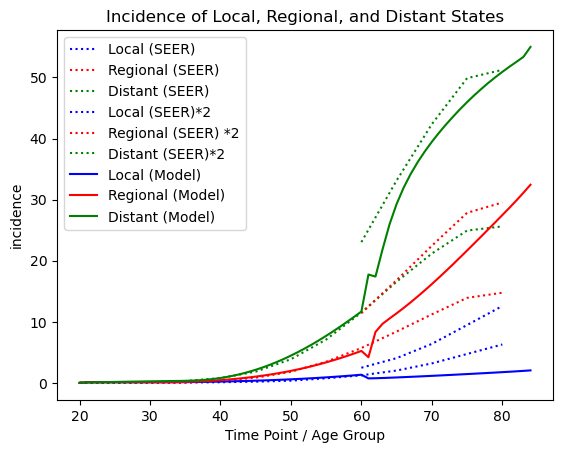

Simulated annealing progress:  61%|██████    | 61019/100000 [10:03<04:29, 144.37iteration/s]

61000 :  297.25159297634923    PDAC:  0.01171    tick: 20776


Simulated annealing progress:  62%|██████▏   | 62024/100000 [10:11<05:04, 124.76iteration/s]

62000 :  297.25159297634923    PDAC:  0.01171    tick: 21776


Simulated annealing progress:  63%|██████▎   | 63030/100000 [10:18<04:18, 142.91iteration/s]

63000 :  297.25159297634923    PDAC:  0.01171    tick: 22776


Simulated annealing progress:  64%|██████▍   | 64025/100000 [10:25<04:17, 139.95iteration/s]

64000 :  297.25159297634923    PDAC:  0.01171    tick: 23776


Simulated annealing progress:  65%|██████▌   | 65025/100000 [10:33<04:22, 133.15iteration/s]

65000 :  297.25159297634923    PDAC:  0.01171    tick: 24776


Simulated annealing progress:  66%|██████▌   | 66015/100000 [10:41<04:03, 139.44iteration/s]

66000 :  297.25159297634923    PDAC:  0.01171    tick: 25776


Simulated annealing progress:  67%|██████▋   | 67019/100000 [10:48<04:54, 111.99iteration/s]

67000 :  297.25159297634923    PDAC:  0.01171    tick: 26776


Simulated annealing progress:  68%|██████▊   | 68020/100000 [10:56<04:01, 132.64iteration/s]

68000 :  297.25159297634923    PDAC:  0.01171    tick: 27776


Simulated annealing progress:  69%|██████▉   | 69015/100000 [11:03<04:30, 114.38iteration/s]

69000 :  297.25159297634923    PDAC:  0.01171    tick: 28776


Simulated annealing progress:  70%|██████▉   | 69999/100000 [11:11<04:10, 119.54iteration/s]

70000 :  297.25159297634923    PDAC:  0.01171    tick: 29776
Progress report, i = 70000
   From State    To State  Probability
0     healthy  u_PDAC_loc     0.000001
1  u_PDAC_loc  u_PDAC_reg     0.303776
2  u_PDAC_reg  u_PDAC_dis     0.602806
3  u_PDAC_loc  d_PDAC_loc     0.011480
4  u_PDAC_reg  d_PDAC_reg     0.059878
5  u_PDAC_dis  d_PDAC_dis     0.102158


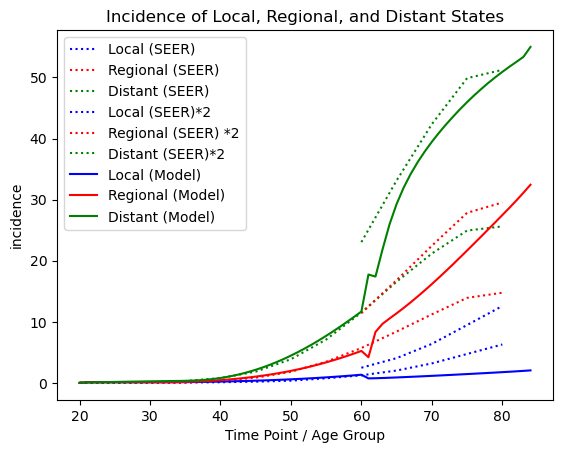

Simulated annealing progress:  71%|███████   | 71020/100000 [11:19<04:28, 107.97iteration/s]

71000 :  297.25159297634923    PDAC:  0.01171    tick: 30776


Simulated annealing progress:  72%|███████▏  | 72017/100000 [11:27<03:21, 139.19iteration/s]

72000 :  297.25159297634923    PDAC:  0.01171    tick: 31776


Simulated annealing progress:  73%|███████▎  | 73014/100000 [11:34<03:13, 139.25iteration/s]

73000 :  297.25159297634923    PDAC:  0.01171    tick: 32776


Simulated annealing progress:  74%|███████▍  | 74019/100000 [11:42<03:15, 133.00iteration/s]

74000 :  297.25159297634923    PDAC:  0.01171    tick: 33776


Simulated annealing progress:  75%|███████▌  | 75017/100000 [11:50<03:12, 130.05iteration/s]

75000 :  297.25159297634923    PDAC:  0.01171    tick: 34776


Simulated annealing progress:  76%|███████▌  | 76016/100000 [11:58<03:14, 123.18iteration/s]

76000 :  297.25159297634923    PDAC:  0.01171    tick: 35776


Simulated annealing progress:  77%|███████▋  | 77013/100000 [12:05<02:40, 143.51iteration/s]

77000 :  297.25159297634923    PDAC:  0.01171    tick: 36776


Simulated annealing progress:  78%|███████▊  | 78019/100000 [12:12<02:32, 143.85iteration/s]

78000 :  297.25159297634923    PDAC:  0.01171    tick: 37776


Simulated annealing progress:  79%|███████▉  | 79023/100000 [12:20<02:35, 135.03iteration/s]

79000 :  297.25159297634923    PDAC:  0.01171    tick: 38776


Simulated annealing progress:  80%|███████▉  | 79997/100000 [12:28<03:36, 92.46iteration/s] 

80000 :  297.25159297634923    PDAC:  0.01171    tick: 39776
Progress report, i = 80000
   From State    To State  Probability
0     healthy  u_PDAC_loc     0.000001
1  u_PDAC_loc  u_PDAC_reg     0.303776
2  u_PDAC_reg  u_PDAC_dis     0.602806
3  u_PDAC_loc  d_PDAC_loc     0.011480
4  u_PDAC_reg  d_PDAC_reg     0.059878
5  u_PDAC_dis  d_PDAC_dis     0.102158


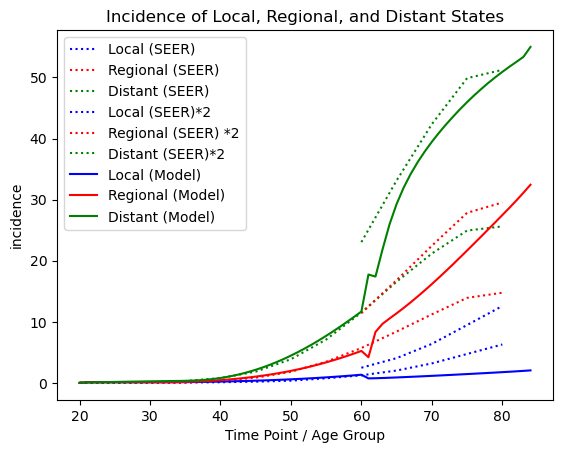

Simulated annealing progress:  81%|████████  | 81024/100000 [12:36<02:25, 130.19iteration/s]

81000 :  297.25159297634923    PDAC:  0.01171    tick: 40776


Simulated annealing progress:  82%|████████▏ | 82015/100000 [12:44<02:21, 126.87iteration/s]

82000 :  297.25159297634923    PDAC:  0.01171    tick: 41776


Simulated annealing progress:  83%|████████▎ | 83022/100000 [12:52<02:09, 130.92iteration/s]

83000 :  297.25159297634923    PDAC:  0.01171    tick: 42776


Simulated annealing progress:  84%|████████▍ | 84032/100000 [13:00<01:55, 138.13iteration/s]

84000 :  297.25159297634923    PDAC:  0.01171    tick: 43776


Simulated annealing progress:  85%|████████▌ | 85031/100000 [13:07<01:40, 148.51iteration/s]

85000 :  297.25159297634923    PDAC:  0.01171    tick: 44776


Simulated annealing progress:  86%|████████▌ | 86011/100000 [13:14<01:41, 137.41iteration/s]

86000 :  297.25159297634923    PDAC:  0.01171    tick: 45776


Simulated annealing progress:  87%|████████▋ | 87015/100000 [13:22<01:45, 123.33iteration/s]

87000 :  297.25159297634923    PDAC:  0.01171    tick: 46776


Simulated annealing progress:  88%|████████▊ | 88022/100000 [13:30<01:21, 146.37iteration/s]

88000 :  297.25159297634923    PDAC:  0.01171    tick: 47776


Simulated annealing progress:  89%|████████▉ | 89021/100000 [13:38<01:28, 124.34iteration/s]

89000 :  297.25159297634923    PDAC:  0.01171    tick: 48776


Simulated annealing progress:  90%|████████▉ | 89992/100000 [13:47<01:43, 96.71iteration/s] 

90000 :  297.25159297634923    PDAC:  0.01171    tick: 49776
Progress report, i = 90000
   From State    To State  Probability
0     healthy  u_PDAC_loc     0.000001
1  u_PDAC_loc  u_PDAC_reg     0.303776
2  u_PDAC_reg  u_PDAC_dis     0.602806
3  u_PDAC_loc  d_PDAC_loc     0.011480
4  u_PDAC_reg  d_PDAC_reg     0.059878
5  u_PDAC_dis  d_PDAC_dis     0.102158


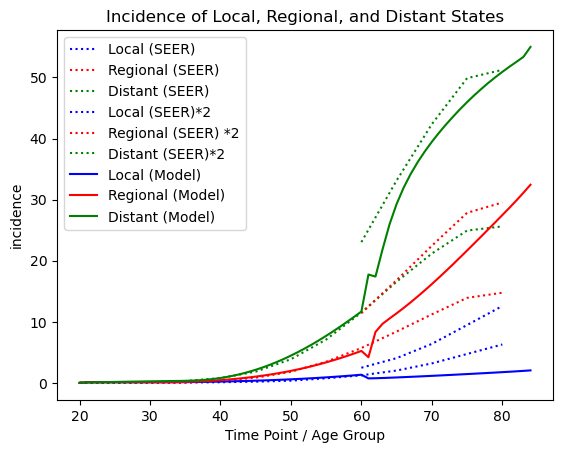

Simulated annealing progress:  91%|█████████ | 91017/100000 [13:55<01:15, 118.31iteration/s]

91000 :  297.25159297634923    PDAC:  0.01171    tick: 50776


Simulated annealing progress:  92%|█████████▏| 92018/100000 [14:03<01:04, 123.67iteration/s]

92000 :  297.25159297634923    PDAC:  0.01171    tick: 51776


Simulated annealing progress:  93%|█████████▎| 93016/100000 [14:11<00:56, 124.35iteration/s]

93000 :  297.25159297634923    PDAC:  0.01171    tick: 52776


Simulated annealing progress:  94%|█████████▍| 94016/100000 [14:18<00:50, 119.32iteration/s]

94000 :  297.25159297634923    PDAC:  0.01171    tick: 53776


Simulated annealing progress:  95%|█████████▌| 95022/100000 [14:27<00:40, 124.38iteration/s]

95000 :  297.25159297634923    PDAC:  0.01171    tick: 54776


Simulated annealing progress:  96%|█████████▌| 96016/100000 [14:35<00:32, 122.72iteration/s]

96000 :  297.25159297634923    PDAC:  0.01171    tick: 55776


Simulated annealing progress:  97%|█████████▋| 97014/100000 [14:43<00:23, 128.77iteration/s]

97000 :  297.25159297634923    PDAC:  0.01171    tick: 56776


Simulated annealing progress:  98%|█████████▊| 98021/100000 [14:51<00:14, 137.22iteration/s]

98000 :  297.25159297634923    PDAC:  0.01171    tick: 57776


Simulated annealing progress:  99%|█████████▉| 99018/100000 [15:00<00:08, 118.72iteration/s]

99000 :  297.25159297634923    PDAC:  0.01171    tick: 58776


Simulated annealing progress: 100%|██████████| 100000/100000 [15:07<00:00, 110.14iteration/s]


297.25159297634923
   From State    To State  Probability
0     healthy  u_PDAC_loc     0.000001
1  u_PDAC_loc  u_PDAC_reg     0.303776
2  u_PDAC_reg  u_PDAC_dis     0.602806
3  u_PDAC_loc  d_PDAC_loc     0.011480
4  u_PDAC_reg  d_PDAC_reg     0.059878
5  u_PDAC_dis  d_PDAC_dis     0.102158


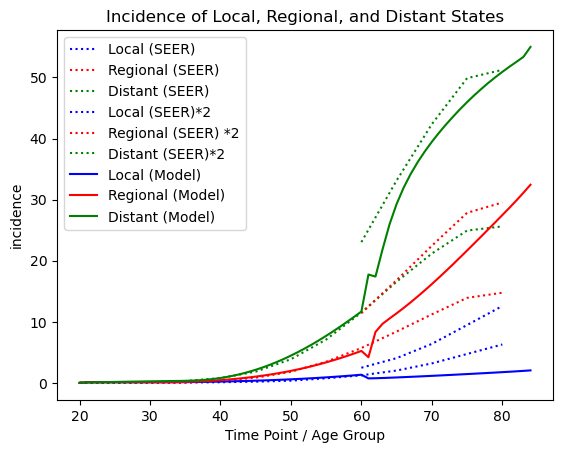

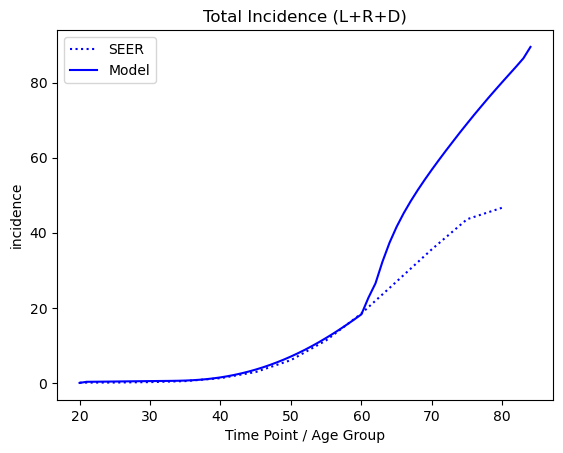

                0          1          2           3          4           5  \
0   100000.000000   0.000000   0.000000    0.000000   0.000000    0.000000   
1    99924.500000   0.100000   0.100000    0.100000   0.100000    0.100000   
2    99839.963949   0.168745   0.165717    0.251026   0.200992    0.204145   
3    99747.711982   0.215841   0.209103    0.427153   0.302654    0.311694   
4    99649.660233   0.247968   0.237655    0.611614   0.404757    0.422071   
5    99547.320383   0.269762   0.256246    0.793567   0.507144    0.534823   
6    99441.402486   0.284431   0.268111    0.966119   0.609701    0.649597   
7    99331.619737   0.294192   0.275422    1.125071   0.712343    0.766111   
8    99217.786369   0.300576   0.279653    1.268072   0.815008    0.884144   
9    99099.023461   0.304633   0.281797    1.394042   0.917643    1.003514   
10   98974.655087   0.307089   0.282533    1.502776   1.020204    1.124075   
11   98844.405466   0.308442   0.282323    1.594665   1.122659  

In [14]:
# Run SA with calibration to 2*seer incidence
out=run_sa(tmat)

In [12]:
c.starting_pop.shape

(9, 41)

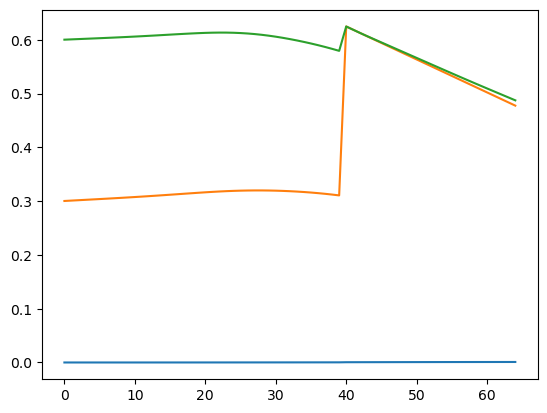

In [39]:
plt.plot(out[:,0,1])
plt.plot(out[:,1,2])
plt.plot(out[:,2,3])
plt.show()

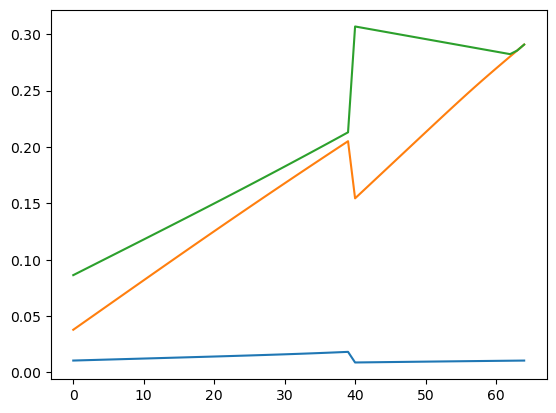

In [ ]:
plt.plot(out[:,1,4])
plt.plot(out[:,2,5])
plt.plot(out[:,3,6])
plt.show()

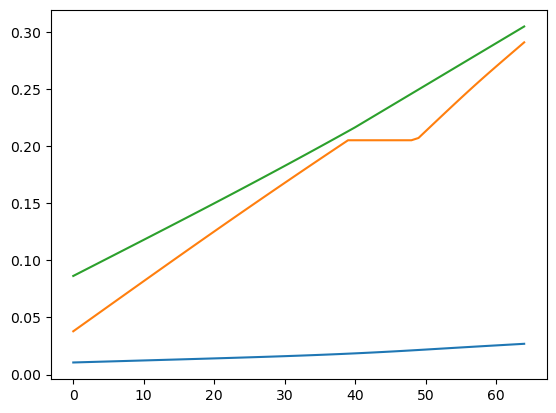

In [50]:
plt.plot(temp[:,1,4])
plt.plot(temp[:,2,5])
plt.plot(temp[:,3,6])
plt.show()

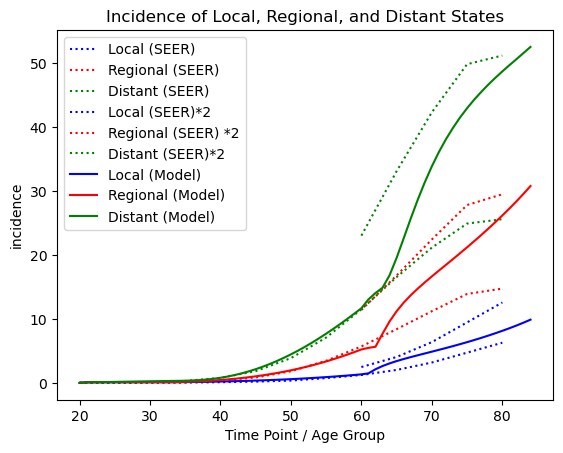

In [49]:
# Manual fuckery
temp = out.copy()
temp[:, 1, 4] = tmat[:, 1, 4]
temp[:, 1, 2] = tmat[:, 1, 2]
temp[40:, 3, 6] = np.linspace(tmat[40, 3, 6], tmat[-1,3,6], 25)
#temp[40:, 2, 3] = np.linspace(tmat[40, 2, 3], tmat[-1,2,3], 25)
temp[:, 2, 5] = np.maximum.accumulate(temp[:,2,5])
# temp[40:, 0, 1] *= 1.2
# temp[40:, 1, 4] *= 1.3
# temp[40:, 2, 5] *= 1.3
temp_small = temp[::5,:,:]
tmat_smoothed = temp.copy()
tmat_smoothed[40:,:,:] = csaps([57.5, 62.5, 67.5,72.5,77.5], temp_small[8:,:,:], axis=0, smooth=0.001)(c.ages_1y[40:])
tmat_smoothed = add_acm(tmat_smoothed)
tmat_smoothed = add_csd(tmat_smoothed)
tmat_smoothed = constrain_matrix(tmat_smoothed)
tmat_smoothed = row_normalize(tmat_smoothed)
log = run_markov(tmat_smoothed)
p.plot_vs_seer(log[0], c.seer_inc)